# Assignment 2

# Grade: /100

## Instructions

* Complete the Lab assignment

* Once the notebook is complete, restart your kernel and rerun your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the Lab assignment.



This notebook contains the questions for Assignment 2. Please note, a random seed has been set to ensure the reproducability of the results -- *DO NOT* change this random seed. **If you call additional functions that are based on random number generators, you will need to define their seed to 42 as well**. Make sure to complete this assignment individually and appropriately reference all external code and documentation used. 

In [2]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, accuracy_score, precision_score

np.random.seed(42)

## Dataset 

This assignment's objective is to develop a data-driven predictive model for the power consumption of an industrial refrigeration system using the `Data_Rack01` dataset.  
The data frame contains the following data, where each row represents a datapoint:

- Dew_Point: the temperature to which air must be cooled to become saturated with water vapor 
- Indoor_Humidity: The indoor Humidity
- Indoor_Temperature: The indoor temprature (Fahrenheit)
- Outdoor_Humidity: The outdoor humidity
- Outdoor_Temperature: The outdoor temprature (Fahrenheit)
- Discharge_Pressure: The pressure generated on the output side of a gas compressor in a refrigeration system
- Discharge_Temperature: The compressor's discharge temperature 
- KW: Power consumed
- Power_Factor: The power factor of the refrigeration system
- Volts_Line_to_Line
- Volts_Line_to_Neutral

## Question 1 (40 pts)

### a) Preprocess the data acording to the following:

1. Load data into a variable called myData
2. In the `myPreProc` function perform the following:
  - Remove the empty column(s), 
  - Drop rows with any missing data ("NA").
  - Remove the 'DeviceName' column as well

The processed data should be returned through the function variable `procData`



In [3]:
#Part 1a

myData = pd.read_csv('Data_Rack01.csv')

def myPreProc(data):
    procData = data.drop(['Discharge_Pressure', 'DeviceName'],axis=1)
    procData = procData.dropna()
    return procData

procData = myPreProc(myData)


### b) Define two loss functions:
- one that measures the absolute difference between observations and predictions. Return mean and standard deviation of the result.
- one that finds the absolute difference that is less than or equal to a threshold. Return mean and standard deviation of the result.



In [5]:
#Part 1b

def abs_diff_loss(obs, pred):
    
    # Resids is an array
    resids = abs(pred-obs)
    
    # Arrays have mean and std methods
    return resids.mean(), resids.std(ddof=1)
    
def threshold_loss(obs, pred, thresh):
    
    # Check if residual is within threshold
    resids = abs(obs-pred)<=thresh
    
    # This turns booleans into ints.  1==True, 0==False
    resids = resids.astype(int)
    return resids.mean(), resids.std(ddof=1)

# Loss function Assert Statement
assert threshold_loss(np.array([1,2,3,4,5]), np.array([5,4,3,2,1]), 2)[0] == 0.6, "Should be 0.6, -10 marks"
assert abs_diff_loss(np.array([1,2,3,4,5]), np.array([5,4,3,2,1]))[0] == 2.4, "Should be 2.4, -10 marks"

### c) Data splitting:
- Use power consumption as the target variable for your machine learning model. 
- Split your preprocessed dataset by setting aside some amount of data for testing, and retaining the rest for training. Reserve 30 percent of your data for testing. *Make sure to set the random_state to 42 if you are using an sklearn function to accomplish this. 


In [6]:
#Part 1c
X = procData.drop('kW', axis = 'columns').values
# DfFeatures = procData.drop('kW', axis = 'columns')
y = procData.kW.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size =0.30, random_state=42)



### d) Build a linear regression model:
- Using Ordinary Least Squares, build a model to predict power consumed (KW) as a `linear function` of the other variables (features) in the dataset. In order to properly build the regression model, the features need to be `standardized` so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build a `pipeline` that **standardizes the features** and **creates a linear regression model**.
- Report the coefficient of determination (`R2 score`) when evaluating both the training and testing performance of your model.

In [7]:
#Part 1d
myLinearModel = Pipeline([
    ('standardize', StandardScaler()),
    ('linear_regression', LinearRegression())
  ])

myLinearModel.fit(Xtrain, ytrain)

trainingPreds = myLinearModel.predict(Xtrain)
testPreds = myLinearModel.predict(Xtest)

trainingR2 = r2_score(ytrain, trainingPreds)
testR2 = r2_score(ytest, testPreds)


print('Trianing R2 score is:',trainingR2 )
print('Test R2 score is:',testR2 )


Trianing R2 score is: 0.4364138509466349
Test R2 score is: 0.4240761933328048


## Question 2 - Regularization (25 pts) 

- Use L2 regularization by adding a penalty of $\lambda \sum_{i}{\beta_i^2}$ (where $\beta_i$ are your regression coefficients) to the regression model. Vary the regularization parameter $\lambda$ between 0.2 and 250, evenly spaced in **log-space**, and generate 50 values. 
- Build the `pipeline` that **standardizes the features** and **create a regularized regression model**.
- Determine the 10-fold crossvalidated performance for different values of the L2-regularization parameters. Use the cross-validated R-Squared (R2) of the data under the model as evaluation criterion.  
- Make a plot of the cross-validated R-Squared (R2) against $log(\lambda)$. 
- Report the best lambda that you found

Best lambda: 0.2


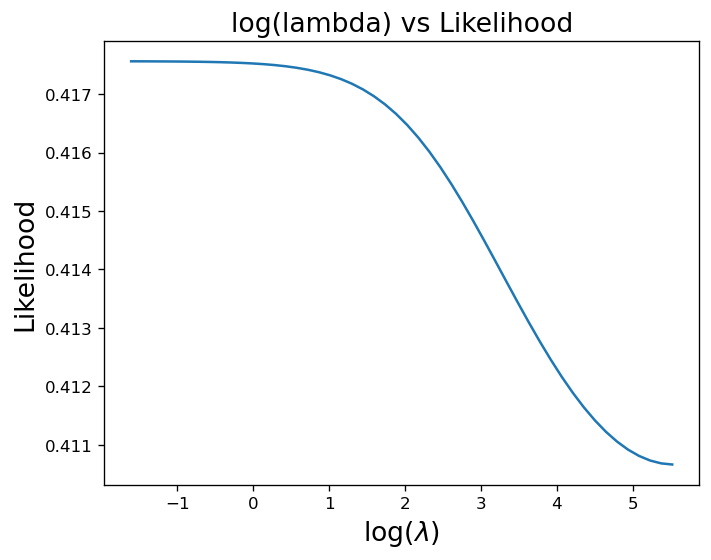

In [8]:
#Solution 1, both answers are acceptable
regularization_strength = np.exp(np.linspace(np.log(0.2),np.log(250),50))

loglike = np.zeros(regularization_strength.size)

for i,L in enumerate(regularization_strength):
    Ridge_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('reg', Ridge(alpha=L, fit_intercept=True)) 
    ])
    
    cv_score = cross_val_score(Ridge_pipe, Xtrain, ytrain, cv=10)
    loglike[i]= cv_score.mean()

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), loglike)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'Likelihood', fontsize = 16)
ax.set_title(r'log(lambda) vs Likelihood', fontsize = 16)


bestL=np.argmax(loglike)
print('Best lambda:',regularization_strength[bestL])

Best lambda: 0.2


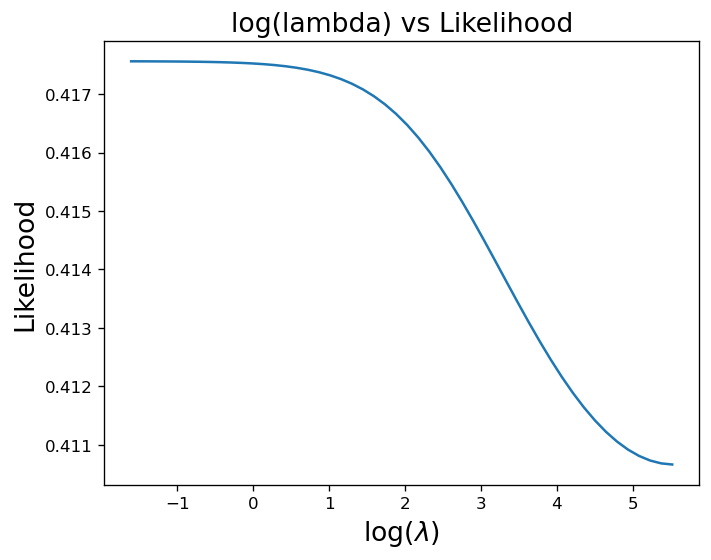

In [9]:
#Solution 2, both answers are acceptable
regularization_strength = np.geomspace(0.2,250,50)

loglike = np.zeros(regularization_strength.size)

for i,L in enumerate(regularization_strength):
    Ridge_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('reg', Ridge(alpha=L, fit_intercept=True)) 
    ])
    
    cv_score = cross_val_score(Ridge_pipe, Xtrain, ytrain, cv=10, scoring = 'r2')
    loglike[i]= cv_score.mean()

fig, ax = plt.subplots(dpi = 120)
ax.plot(np.log(regularization_strength), loglike)
ax.set_xlabel(r'$\log(\lambda)$', fontsize = 16)
ax.set_ylabel(r'Likelihood', fontsize = 16)
ax.set_title(r'log(lambda) vs Likelihood', fontsize = 16)


bestL=np.argmax(loglike)
print('Best lambda:',regularization_strength[bestL])

## Question 3 - Classification (35 pts)

### a) Binary target:
- Convert your target variable in the dataset into a binary variable using >= mean thresholding (use the same data split as in Q1 part c). 


In [10]:
#Part 3a
mean_thresh = np.mean(ytrain)
ytrain = ytrain >= mean_thresh
ytest = ytest >= mean_thresh



### b) Build logistic regression model:
- Define a Logistic Regression model and report the resulting *training* precision and *testing* accuracy of your model. Make sure the set the maximum number of iterations for your model to 10000 (use pipeline for normalization and model building same as Questions 1 and 2).


In [11]:
#Part 3b
myLogRegModel = Pipeline([
    ('scale', StandardScaler()),
    ('LogReg', LogisticRegression(max_iter=10000)) 
    ])

myLogRegModel.fit(Xtrain, ytrain)
precision = precision_score(ytrain, myLogRegModel.predict(Xtrain))
accuracy = accuracy_score(ytest, myLogRegModel.predict(Xtest))

print("Training precision:",precision )
print("Test accuracy:",accuracy )


Training precision: 0.804956988331488
Test accuracy: 0.8020968159461558


### c) Build a Support Vector Machine (SVM) model:
- Define a linear SVM model with default options and maximum number of iterations 10000. Report the resulting *training* precision and *testing* accuracy of your model (use pipeline for normalization and model building same as Questions 1 and 2).



In [12]:
#Part 3c

mySVM = Pipeline([
    ('scale', StandardScaler()),
    ('linSVM', LinearSVC(max_iter=10000)) 
    ])
mySVM.fit(Xtrain, ytrain)
precision = precision_score(ytrain, mySVM.predict(Xtrain))
accuracy = accuracy_score(ytest, mySVM.predict(Xtest))

print("Training precision:",precision )
print("Test accuracy:",accuracy )


Training precision: 0.7838938197215211
Test accuracy: 0.7881180429717836


### d) Comparison:
- Compare the performance of your models in `b` and `c` in terms of generalization performance and execution time, what do you conclude? 

*Part 3d*

`Written Answer:`LR has better generalization performance (higher test accuracy) and less complexity. 